In [16]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
from itertools import combinations
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm
from scipy.stats import zscore
from sklearn.model_selection import ParameterSampler
from sklearn.linear_model import Ridge
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import requests
from bs4 import BeautifulSoup

warnings.filterwarnings("ignore")

In [17]:
def get_sp500_tickers():
    """
    Scrape S&P 500 tickers and their sectors from Wikipedia.
    
    Returns:
        sp500_df (DataFrame): DataFrame containing tickers and their sectors.
    """
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception('Failed to load S&P 500 page')

    soup = BeautifulSoup(response.text, 'lxml')
    table = soup.find('table', {'id': 'constituents'})
    sp500_df = pd.read_html(str(table))[0]
    sp500_df['Symbol'] = sp500_df['Symbol'].str.replace('.', '-', regex=False)  
    return sp500_df[['Symbol', 'GICS Sector']]

def download_price_data(tickers, start_date, end_date):
    """
    Download adjusted close price data for given tickers using yfinance.
    
    Parameters:
        tickers (list): List of ticker symbols.
        start_date (str): Start date in 'YYYY-MM-DD'.
        end_date (str): End date in 'YYYY-MM-DD'.
        
    Returns:
        price_data (DataFrame): DataFrame of adjusted close prices.
        valid_tickers (list): List of tickers successfully downloaded.
    """
    failed_tickers = []
    valid_tickers = []
    price_data = pd.DataFrame()

    for ticker in tickers:
        try:
            data = yf.download(ticker, start=start_date, end=end_date, progress=False)['Adj Close']
            if data.empty:
                failed_tickers.append(ticker)
            else:
                price_data[ticker] = data
                valid_tickers.append(ticker)
        except Exception as e:
            print(f"Failed to download {ticker}: {e}")
            failed_tickers.append(ticker)

    if failed_tickers:
        print(f"\nFailed to download the following tickers and will be excluded from analysis: {failed_tickers}\n")

    price_data.index = pd.to_datetime(price_data.index)
    price_data = price_data.sort_index()
    return price_data, valid_tickers


def generate_sector_pairs(sp500_df, selected_sectors, price_data, min_corr=0.8, top_n=10):
    """
    Generate top N highly correlated pairs within selected sectors.
    
    Parameters:
        sp500_df (DataFrame): DataFrame containing tickers and their sectors.
        selected_sectors (list): List of sectors to include.
        price_data (DataFrame): DataFrame of adjusted close prices.
        min_corr (float): Minimum correlation threshold.
        top_n (int): Number of top pairs per sector.
        
    Returns:
        sector_pairs (list): List of tuples representing pairs.
    """
    # Group tickers by sector
    sector_groups = sp500_df[sp500_df['GICS Sector'].isin(selected_sectors)].groupby('GICS Sector')['Symbol'].apply(list)
    sector_pairs = []

    for sector, tickers in sector_groups.items():
        if len(tickers) < 2:
            continue  # Need at least two tickers to form a pair
        # Filter tickers present in price_data
        tickers = [ticker for ticker in tickers if ticker in price_data.columns]
        if len(tickers) < 2:
            continue

        corr_matrix = price_data[tickers].corr().abs()
        corr_pairs = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        corr_pairs = corr_pairs.stack().reset_index()
        corr_pairs.columns = ['Stock1', 'Stock2', 'Correlation']
        # Filter pairs by minimum correlation
        corr_pairs = corr_pairs[corr_pairs['Correlation'] >= min_corr]
        if corr_pairs.empty:
            continue
        corr_pairs = corr_pairs.sort_values(by='Correlation', ascending=False)
        top_pairs = corr_pairs.head(top_n)
        for _, row in top_pairs.iterrows():
            sector_pairs.append((row['Stock1'], row['Stock2']))
    return sector_pairs

def calculate_cointegration_for_pair(pair, price_data):
    """
    Calculate cointegration metrics for a given pair.
    
    Parameters:
        pair (tuple): Tuple containing two ticker symbols.
        price_data (DataFrame): DataFrame of adjusted close prices.
        
    Returns:
        result (dict): Dictionary containing pair and its metrics.
    """
    stock1, stock2 = pair
    series1 = price_data[stock1]
    series2 = price_data[stock2]
    try:
        # Perform cointegration test
        score, pvalue, _ = coint(series1, series2)
        # Calculate correlation
        corr = series1.corr(series2)
        # Calculate spread and its statistics
        spread = series1 - series2
        spread_mean = spread.mean()
        spread_std = spread.std()
        return {
            'Pair': pair,
            'P-Value': pvalue,
            'Correlation': corr,
            'Spread Mean': spread_mean,
            'Spread Std': spread_std
        }
    except Exception as e:
        print(f"Error processing pair {pair}: {e}")
        return None

def calculate_cointegration(pairs, price_data):
    """
    Calculate cointegration metrics for a list of pairs sequentially.
    
    Parameters:
        pairs (list): List of ticker pairs.
        price_data (DataFrame): DataFrame of adjusted close prices.
        
    Returns:
        coint_df (DataFrame): DataFrame containing pairs with their metrics.
    """
    results = []
    for pair in pairs:
        res = calculate_cointegration_for_pair(pair, price_data)
        if res is not None:
            results.append(res)
    coint_df = pd.DataFrame(results)
    return coint_df

def normalize_series(series):
    """
    Normalize a pandas Series to the range [0, 1].
    
    Parameters:
        series (Series): Pandas Series to normalize.
        
    Returns:
        normalized_series (Series): Normalized Series.
    """
    min_val = series.min()
    max_val = series.max()
    if max_val - min_val == 0:
        return series - min_val
    normalized_series = (series - min_val) / (max_val - min_val)
    return normalized_series

def calculate_composite_score(coint_df, weights):
    """
    Calculate a composite score for each pair based on multiple metrics.
    
    Parameters:
        coint_df (DataFrame): DataFrame containing pairs and their metrics.
        weights (dict): Weights for each metric.
        
    Returns:
        coint_df (DataFrame): DataFrame with an additional 'Composite Score' column.
    """
    
    coint_df['P-Value Norm'] = normalize_series(coint_df['P-Value'])
    coint_df['Correlation Norm'] = normalize_series(coint_df['Correlation'])
    coint_df['Spread Mean Norm'] = normalize_series(coint_df['Spread Mean'])
    coint_df['Spread Std Norm'] = normalize_series(coint_df['Spread Std'])
    
    # Invert P-Value normalization since lower p-values are better
    coint_df['P-Value Norm Inv'] = 1 - coint_df['P-Value Norm']
    
    coint_df['Composite Score'] = (
        coint_df['P-Value Norm Inv'] * weights.get('pvalue', 1) +
        coint_df['Correlation Norm'] * weights.get('correlation', 1) +
        coint_df['Spread Mean Norm'] * weights.get('spread_mean', 1) +
        coint_df['Spread Std Norm'] * weights.get('spread_std', 1)
    )
    
    return coint_df

def select_top_pairs(coint_df, top_n_per_sector):
    """
    Select top N pairs based on composite score.
    
    Parameters:
        coint_df (DataFrame): DataFrame containing pairs and their metrics.
        top_n_per_sector (int): Number of top pairs to select.
        
    Returns:
        selected_pairs (list): List of selected ticker pairs.
    """
    
    coint_df = coint_df.sort_values('Composite Score', ascending=False)
    selected_pairs = coint_df.head(top_n_per_sector)['Pair'].tolist()
    return selected_pairs

Fetching S&P 500 tickers and sectors...



1 Failed download:
['AMTM']: Exception("%ticker%: Data doesn't exist for startDate = 1577854800, endDate = 1698724800")

1 Failed download:
['GEV']: Exception("%ticker%: Data doesn't exist for startDate = 1577854800, endDate = 1698724800")

1 Failed download:
['SW']: Exception("%ticker%: Data doesn't exist for startDate = 1577854800, endDate = 1698724800")

1 Failed download:
['SOLV']: Exception("%ticker%: Data doesn't exist for startDate = 1577854800, endDate = 1698724800")



Failed to download the following tickers and will be excluded from analysis: ['AMTM', 'GEV', 'SW', 'SOLV']

Downloaded price data for 499 tickers.
Trading end date '2023-10-31' not found in data. Adjusted to last available date '2023-10-30'.

Starting parameter optimization...
Total sector pairs after pre-filtering: 30
Completed cointegration testing for 30 pairs.

Testing parameter set 1/20: {'z_exit': 0.5, 'z_entry': 2.0, 'pvalue_threshold': 0.05}
Selected 4 pairs for backtesting.
Sharpe Ratio: nan

Testing parameter set 2/20: {'z_exit': 0.7, 'z_entry': 2.5, 'pvalue_threshold': 0.03}
Selected 3 pairs for backtesting.
Sharpe Ratio: 14.8785

Testing parameter set 3/20: {'z_exit': 1.0, 'z_entry': 2.5, 'pvalue_threshold': 0.03}
Selected 3 pairs for backtesting.
Sharpe Ratio: 14.8577

Testing parameter set 4/20: {'z_exit': 0.7, 'z_entry': 2.5, 'pvalue_threshold': 0.05}
Selected 4 pairs for backtesting.
Sharpe Ratio: nan

Testing parameter set 5/20: {'z_exit': 1.0, 'z_entry': 2.5, 'pvalue

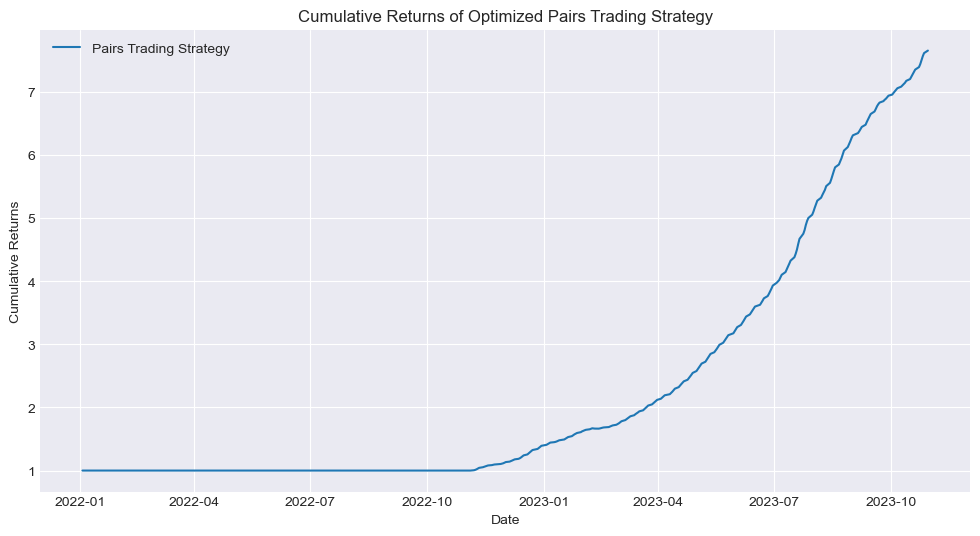

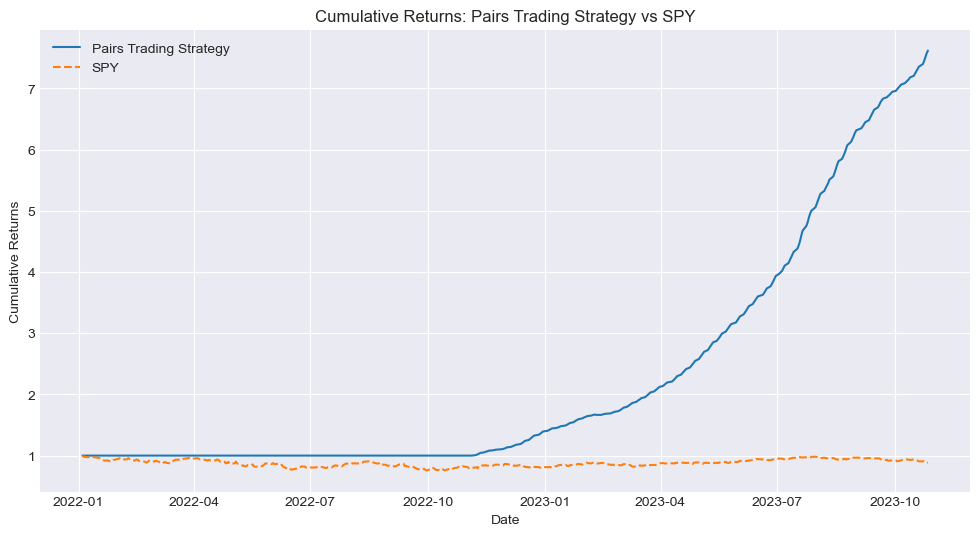


Performance Summary:


,Pairs Trading Strategy,SPY
Total Return,6.616260,-0.116672
Sharpe Ratio,14.887822,-0.240023
Max Drawdown,-0.003471,-0.244711


In [18]:
class PairsTradingStrategy:
    def __init__(self, price_data, initial_capital=1_000_000, transaction_cost=0.001):
        """
        Initialize the pairs trading strategy.
        
        Parameters:
            price_data (DataFrame): DataFrame of adjusted close prices.
            initial_capital (float): Starting capital.
            transaction_cost (float): Transaction cost per trade (as a decimal).
        """
        self.price_data = price_data
        self.initial_capital = initial_capital
        self.transaction_cost = transaction_cost
        self.positions = {}  

    def compute_zscore(self, spread):
        """
        Compute the z-score of a spread.
        
        Parameters:
            spread (Series): Spread between two stock prices.
            
        Returns:
            zscore (Series): Z-score of the spread.
        """
        return (spread - spread.mean()) / spread.std()

    def backtest(self, selected_pairs, z_entry, z_exit, trading_period_start, trading_period_end):
        """
        Backtest the pairs trading strategy.
        
        Parameters:
            selected_pairs (list): List of selected ticker pairs.
            z_entry (float): Z-score threshold for entering a trade.
            z_exit (float): Z-score threshold for exiting a trade.
            trading_period_start (str): Start date of trading period.
            trading_period_end (str): End date of trading period.
            
        Returns:
            daily_returns (Series): Daily returns of the strategy.
            portfolio_values (Series): Daily portfolio values.
        """
        # Initialize portfolio value series
        portfolio_dates = self.price_data.loc[trading_period_start:trading_period_end].index
        portfolio_values = pd.Series(index=portfolio_dates)
        portfolio_values.iloc[0] = self.initial_capital  
        cash = self.initial_capital
        positions = {}

        for i, date in enumerate(portfolio_dates):
            if i > 0:
                portfolio_values.iloc[i] = portfolio_values.iloc[i-1]
            
            for pair in selected_pairs:
                stock1, stock2 = pair
                if stock1 not in self.price_data.columns or stock2 not in self.price_data.columns:
                    continue
                if date not in self.price_data.index:
                    continue
                price1 = self.price_data.loc[date, stock1]
                price2 = self.price_data.loc[date, stock2]
                if np.isnan(price1) or np.isnan(price2):
                    continue
                spread = price1 - price2
                current_spread_series = self.price_data.loc[:date, stock1] - self.price_data.loc[:date, stock2]
                if current_spread_series.std() == 0:
                    continue  
                zscore = self.compute_zscore(current_spread_series)[date]

                # Enter trade if z-score exceeds threshold and no existing position
                if zscore > z_entry and pair not in positions:
                    # Short spread: short stock1, long stock2
                    allocation = portfolio_values.iloc[i] / len(selected_pairs) / 2  # Allocate equally
                    shares1 = allocation / price1
                    shares2 = allocation / price2
                    positions[pair] = {'type': 'short_spread', 'shares1': shares1, 'shares2': shares2}
                    # Deduct allocation and transaction costs from cash
                    cash -= 2 * allocation  # Allocate capital to both stocks
                    cash -= 2 * allocation * self.transaction_cost  # Transaction costs
                    portfolio_values.iloc[i] -= 2 * allocation * self.transaction_cost  # Reflect transaction costs

                elif zscore < -z_entry and pair not in positions:
                    # Long spread: long stock1, short stock2
                    allocation = portfolio_values.iloc[i] / len(selected_pairs) / 2  # Allocate equally
                    shares1 = allocation / price1
                    shares2 = allocation / price2
                    positions[pair] = {'type': 'long_spread', 'shares1': shares1, 'shares2': shares2}
                    # Deduct allocation and transaction costs from cash
                    cash -= 2 * allocation  
                    cash -= 2 * allocation * self.transaction_cost  
                    portfolio_values.iloc[i] -= 2 * allocation * self.transaction_cost  

                # Exit trade if z-score reverts below exit threshold
                if pair in positions:
                    position = positions[pair]
                    current_z = zscore
                    if abs(current_z) < z_exit:
                        # Calculate PnL based on position type
                        if position['type'] == 'short_spread':
                            pnl = (self.price_data.loc[date, stock1] - price1) * position['shares1'] + \
                                  (price2 - self.price_data.loc[date, stock2]) * position['shares2']
                        elif position['type'] == 'long_spread':
                            pnl = (price1 - self.price_data.loc[date, stock1]) * position['shares1'] + \
                                  (self.price_data.loc[date, stock2] - price2) * position['shares2']
                    
                        cash += pnl
                        closing_cost = 2 * (position['shares1'] * price1 + position['shares2'] * price2) * self.transaction_cost
                        cash -= closing_cost
                        portfolio_values.iloc[i] += pnl - closing_cost
                        del positions[pair]

            total_position_value = 0
            for pair, position in positions.items():
                stock1, stock2 = pair
                price1 = self.price_data.loc[date, stock1]
                price2 = self.price_data.loc[date, stock2]
                if position['type'] == 'short_spread':
                    # Short stock1 and long stock2
                    total_position_value += -position['shares1'] * price1 + position['shares2'] * price2
                elif position['type'] == 'long_spread':
                    # Long stock1 and short stock2
                    total_position_value += position['shares1'] * price1 - position['shares2'] * price2
            portfolio_values.iloc[i] += total_position_value

            if portfolio_values.iloc[i] < 0:
                portfolio_values.iloc[i] = 0

        # Handle any open positions at the end of the trading period
        if trading_period_end not in self.price_data.index:
            last_available_date = self.price_data.index.max()
            print(f"Trading end date '{trading_period_end}' not found. Adjusted to last available date '{last_available_date}'.")
            trading_period_end = last_available_date.strftime('%Y-%m-%d')

        for pair in list(positions.keys()):
            stock1, stock2 = pair
            price1 = self.price_data.loc[trading_period_end, stock1]
            price2 = self.price_data.loc[trading_period_end, stock2]
            position = positions[pair]
            if position['type'] == 'short_spread':
                pnl = (self.price_data.loc[trading_period_end, stock1] - price1) * position['shares1'] + \
                      (price2 - self.price_data.loc[trading_period_end, stock2]) * position['shares2']
            elif position['type'] == 'long_spread':
                pnl = (price1 - self.price_data.loc[trading_period_end, stock1]) * position['shares1'] + \
                      (self.price_data.loc[trading_period_end, stock2] - price2) * position['shares2']
            cash += pnl
            closing_cost = 2 * (position['shares1'] * price1 + position['shares2'] * price2) * self.transaction_cost
            cash -= closing_cost
            portfolio_values.loc[trading_period_end] += pnl - closing_cost
            del positions[pair]

        daily_returns = portfolio_values.pct_change().fillna(0)

        return daily_returns, portfolio_values

def calculate_cumulative_returns(daily_returns):
    """
    Calculate cumulative returns from daily returns.
    
    Parameters:
        daily_returns (Series): Daily returns of the strategy.
        
    Returns:
        cumulative_returns (Series): Cumulative returns over time.
    """
    cumulative_returns = (1 + daily_returns).cumprod()
    return cumulative_returns

def sharpe_ratio(returns, risk_free_rate=0):
    """
    Calculate the Sharpe Ratio of the returns.
    
    Parameters:
        returns (Series): Daily returns of the strategy.
        risk_free_rate (float): Risk-free rate (annualized).
        
    Returns:
        sharpe (float): Sharpe Ratio.
    """
    excess_returns = returns - risk_free_rate / 252  
    return np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(252)  

def max_drawdown(cumulative_returns):
    """
    Calculate the maximum drawdown of the cumulative returns.
    
    Parameters:
        cumulative_returns (Series): Cumulative returns over time.
        
    Returns:
        drawdown (float): Maximum drawdown value.
    """
    roll_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - roll_max) / roll_max
    return drawdown.min()

def performance_summary(daily_returns):
    """
    Generate a performance summary.
    
    Parameters:
        daily_returns (Series): Daily returns of the strategy.
        
    Returns:
        summary (dict): Dictionary containing performance metrics.
    """
    cumulative = calculate_cumulative_returns(daily_returns)
    sharpe = sharpe_ratio(daily_returns)
    mdd = max_drawdown(cumulative)
    total_return = cumulative.iloc[-1] - 1
    summary = {
        'Total Return': total_return,
        'Sharpe Ratio': sharpe,
        'Max Drawdown': mdd
    }
    return summary

def optimize_parameters(sp500_df, price_data, sector_dict, calibration_start, calibration_end, trading_start, trading_end, param_grid, selected_sectors, min_corr=0.8, top_n=10, n_iter=20):
    """
    Optimize strategy parameters using Random Search with a reduced number of pairs.
    
    Parameters:
        sp500_df (DataFrame): DataFrame containing tickers and sectors.
        price_data (DataFrame): DataFrame of adjusted close prices.
        sector_dict (dict): Dictionary mapping tickers to their sectors.
        calibration_start (str): Start date for calibration period.
        calibration_end (str): End date for calibration period.
        trading_start (str): Start date for trading period.
        trading_end (str): End date for trading period.
        param_grid (dict): Dictionary of parameter ranges.
        selected_sectors (list): List of sectors to include in analysis.
        min_corr (float): Minimum correlation threshold for pre-filtering.
        top_n (int): Number of top correlated pairs per sector.
        n_iter (int): Number of random parameter combinations to try.
        
    Returns:
        best_params (dict): Best parameter combination found.
        best_performance (dict): Performance metrics of the best parameters.
        best_daily_returns (Series): Daily returns of the best strategy.
    """
    from sklearn.model_selection import ParameterSampler

    sector_pairs = generate_sector_pairs(sp500_df, selected_sectors, price_data, min_corr=min_corr, top_n=top_n)
    print(f"Total sector pairs after pre-filtering: {len(sector_pairs)}")

    if not sector_pairs:
        raise Exception("No pairs found after applying correlation filter. Consider lowering the min_corr or increasing top_n.")

    #Perform cointegration testing on calibration period
    calibration_start_dt = pd.to_datetime(calibration_start)
    calibration_end_dt = pd.to_datetime(calibration_end)
    calibration_price_data = price_data.loc[calibration_start_dt:calibration_end_dt]

    coint_df = calculate_cointegration(sector_pairs, calibration_price_data)
    print(f"Completed cointegration testing for {coint_df.shape[0]} pairs.")

    # Calculate composite score
    weights = {
        'pvalue': 0.4,
        'correlation': 0.3,
        'spread_mean': 0.2,
        'spread_std': 0.1
    }
    coint_df = calculate_composite_score(coint_df, weights)

    # Sample parameter combinations using Random Search
    param_list = list(ParameterSampler(param_grid, n_iter=n_iter, random_state=42))

    best_sharpe = -np.inf
    best_params = None
    best_daily_returns = None

    for idx, params in enumerate(param_list):
        print(f"\nTesting parameter set {idx+1}/{n_iter}: {params}")
        pvalue_threshold = params['pvalue_threshold']
        z_entry = params['z_entry']
        z_exit = params['z_exit']

        # Filter pairs based on pvalue_threshold
        filtered_pairs = coint_df[coint_df['P-Value'] < pvalue_threshold]
        if filtered_pairs.empty:
            print("No pairs found with the given p-value threshold.")
            continue

        selected_pairs = filtered_pairs.sort_values('Composite Score', ascending=False)['Pair'].tolist()
        print(f"Selected {len(selected_pairs)} pairs for backtesting.")

        strategy = PairsTradingStrategy(price_data, initial_capital=1_000_000, transaction_cost=0.001)
        daily_returns, portfolio_values = strategy.backtest(
            selected_pairs,
            z_entry=z_entry,
            z_exit=z_exit,
            trading_period_start=trading_start,
            trading_period_end=trading_end
        )


        summary = performance_summary(daily_returns)
        sharpe = summary['Sharpe Ratio']
        print(f"Sharpe Ratio: {sharpe:.4f}")

        if sharpe > best_sharpe:
            best_sharpe = sharpe
            best_params = params
            best_daily_returns = daily_returns

    if best_params is None:
        raise Exception("No valid parameter set found. Consider adjusting the parameter grid or filtering criteria.")

    best_performance = performance_summary(best_daily_returns)
    return best_params, best_performance, best_daily_returns

def main():
    # time periods can be adjusted
    calibration_start = '2021-01-01'
    calibration_end = '2021-12-31'
    trading_start = '2022-01-01'
    trading_end = '2023-10-31'

    selected_sectors = ['Information Technology', 'Health Care', 'Financials']  # can be adjusted

    print("Fetching S&P 500 tickers and sectors...")
    sp500_df = get_sp500_tickers()
    sector_dict = dict(zip(sp500_df['Symbol'], sp500_df['GICS Sector']))

    print("Downloading price data...")
    all_tickers = sp500_df['Symbol'].tolist()
    price_data, valid_tickers = download_price_data(all_tickers, start_date='2020-01-01', end_date='2023-10-31')
    print(f"Downloaded price data for {price_data.shape[1]} tickers.")

    param_grid = {
        'pvalue_threshold': [0.01, 0.02, 0.03, 0.04, 0.05],
        'z_entry': [1.5, 2.0, 2.5],
        'z_exit': [0.5, 0.7, 1.0]
    }

    top_n_per_sector = 10  # can be adjusted

    if trading_end not in price_data.index:
        last_available_date = price_data.index.max()
        print(f"Trading end date '{trading_end}' not found in data. Adjusted to last available date '{last_available_date.date()}'.")
        trading_end_adjusted = last_available_date.strftime('%Y-%m-%d')
    else:
        trading_end_adjusted = trading_end

    print("\nStarting parameter optimization...")
    best_params, best_performance, best_daily_returns = optimize_parameters(
        sp500_df, 
        price_data, 
        sector_dict, 
        calibration_start, 
        calibration_end, 
        trading_start, 
        trading_end_adjusted, 
        param_grid, 
        selected_sectors, 
        min_corr=0.8, 
        top_n=top_n_per_sector, 
        n_iter=20
    )

    print("\nOptimization Complete!")
    print(f"Best Parameters: {best_params}")
    print(f"Performance: {best_performance}")

    cumulative_returns = calculate_cumulative_returns(best_daily_returns)
    plt.figure(figsize=(12, 6))
    plt.plot(cumulative_returns, label='Pairs Trading Strategy')
    plt.title('Cumulative Returns of Optimized Pairs Trading Strategy')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.grid(True)
    plt.show()

    print("\nDownloading SPY data for benchmark comparison...")
    spy_data = yf.download('SPY', start=trading_start, end=trading_end_adjusted, progress=False)['Adj Close']
    spy_data = spy_data.dropna()
    spy_data.index = pd.to_datetime(spy_data.index)
    spy_data = spy_data.sort_index()
    spy_returns = spy_data.pct_change().dropna()
    strategy_returns = best_daily_returns.loc[spy_returns.index]
    strategy_returns = strategy_returns.dropna()
    spy_returns = spy_returns.loc[strategy_returns.index]  # Align indices
    strategy_cum = calculate_cumulative_returns(strategy_returns)
    spy_cum = calculate_cumulative_returns(spy_returns)

    plt.figure(figsize=(12, 6))
    plt.plot(strategy_cum, label='Pairs Trading Strategy')
    plt.plot(spy_cum, label='SPY', linestyle='--')
    plt.title('Cumulative Returns: Pairs Trading Strategy vs SPY')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.grid(True)
    plt.show()

    final_summary = performance_summary(strategy_returns)
    spy_summary = performance_summary(spy_returns)
    summary_df = pd.DataFrame({
        'Pairs Trading Strategy': final_summary,
        'SPY': spy_summary
    })
    print("\nPerformance Summary:")
    display(summary_df)

if __name__ == "__main__":
    main()
